# Replay Error Analysis for IEEE118 Node Fault Case

This notebook explores the reconstruction accuracy of replayed curves in the IEEE118 Node Fault case using Dynawo 1.8.0. The analysis focuses on comparing replayed curves with reference curves to evaluate discrepancies and understand the behavior of the system under fault conditions.

The process begins by preparing the replayable case, where the IEEE118 Node Fault scenario is loaded and configured using the `dynawo_replay` library. Once the setup is complete, all replayable elements are locally replayed, and the resulting data is stored for further analysis. Reference curves are then computed for all elements and variables, serving as a baseline for comparison.

Reconstruction metrics are calculated by comparing the replayed curves against the reference curves. These metrics include measures such as peak-to-peak differences, steady-state value differences, and root mean square error (RMSE). The metrics provide insights into the accuracy of the replayed curves and help identify any significant deviations.

The notebook also delves into the distribution of these metrics, highlighting outliers and exploring potential correlations, such as the relationship between reconstruction error and the distance to the fault. Visualizations are used extensively to illustrate the findings, offering a clearer understanding of the system's response and pinpointing areas of interest.


In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm

from dynawo_replay import ReplayableCase
from dynawo_replay.plotting import plot_curves_comparison
from dynawo_replay.metrics import compare_curves

case = ReplayableCase(
    "./data/IEEE118_NodeFault/IEEE118.jobs",
    dynawo="./dynawo-1.8.0",
)

First of all, the case needs to be prepared for replay, so let's execute the `generate_replayable_base()` method.

In [2]:
case.generate_replayable_base()

We next compute the full list of all possible curves to be replayed here.

In [3]:
print(f"Total number of replayable elements: {len(case.replayable_elements)}.")
all_curves = [
    (el.id, v.name)
    for el in case.replayable_elements.values()
    for v in el.replayable_variables
]
print(f"Total number of replayable curves: {len(all_curves)}.")

Total number of replayable elements: 54.
Total number of replayable curves: 6210.


We perform now a local replay of each one of these 54 replayable elements, ouputting all possible variables for each one of them. We store all the resulting dataframes in a dictionary.

In [4]:
replayed_dfs = {}
for el in tqdm(case.replayable_elements.values(), total=len(case.replayable_elements)):
    _all_variables = [v.name for v in el.replayable_variables]
    replayed_dfs[el.id] = case.replay(el.id, _all_variables)

100%|██████████| 54/54 [22:26<00:00, 24.94s/it]


To compute the `reference_df` used for comparing replayed curves and obtaining reconstruction metrics, we retrieve all curves at once. We can achieve this by using the `calculate_reference_curves_many_elements()` method, which accepts a list of tuples `(element_id, variable_name)` as input.

In [5]:
reference_df = case.calculate_reference_curves_many_elements(all_curves)

Now we can build a dataframe with the reconstruction metrics of all curves.

In [6]:
_data = []
for e, v in tqdm(all_curves):
    colname = f"{e}_{v}"
    metrics = compare_curves(reference_df[colname], replayed_dfs[e][colname])
    _data.append(
        {
            "element_id": e,
            "variable": v,
            "lib": case.replayable_elements[e].lib,
            **metrics.__dict__,
        }
    )

metrics_df = pd.DataFrame(_data)
metrics_df

100%|██████████| 6210/6210 [00:39<00:00, 157.40it/s]


,element_id,variable,lib,ptp_ref,ptp_rep,ptp_diff,ss_value_ref,ss_value_rep,ss_value_diff,ss_time_ref,ss_time_rep,ss_time_diff,ptp_diff_rel,ss_value_diff_rel,r2,rmse,nrmse,mae
0,B1-G1,generator_IRotorPu_value,GeneratorSynchronousThreeWindingsProportionalR...,0.184885,1.783588e-01,6.526242e-03,9.337990e-01,9.338064e-01,7.446547e-06,3.380000,3.38,0.000000,0.035299,7.974464e-06,9.598740e-01,3.811435e-03,0.020615,3.628130e-04
1,B1-G1,generator_IStatorPu_value,GeneratorSynchronousThreeWindingsProportionalR...,0.332413,3.214097e-01,1.100329e-02,3.252000e-02,3.250532e-02,1.468152e-05,4.477649,4.48,0.002351,0.033101,4.514612e-04,9.372672e-01,8.809055e-03,0.026500,8.414587e-04
2,B1-G1,generator_MdSatPPu,GeneratorSynchronousThreeWindingsProportionalR...,0.000000,9.313386e-09,9.313386e-09,1.420000e+00,1.420000e+00,3.417266e-13,0.000000,0.00,0.000000,NaN,2.406526e-13,-1.972730e+12,3.118703e-10,NaN,2.341258e-11
3,B1-G1,generator_MqSatPPu,GeneratorSynchronousThreeWindingsProportionalR...,0.000000,5.771658e-09,5.771658e-09,8.800000e-01,8.800000e-01,7.693846e-14,0.000000,0.00,0.000000,NaN,8.743006e-14,-7.575384e+11,1.932603e-10,NaN,1.439411e-11
4,B1-G1,generator_PGen,GeneratorSynchronousThreeWindingsProportionalR...,9.211557,9.191482e+00,2.007514e-02,NaN,NaN,NaN,NaN,NaN,NaN,0.002179,NaN,9.670892e-01,2.009348e-01,0.021813,4.141406e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6205,B116-G1,voltageRegulator_limiterWithLag_initSaturatedMin,GeneratorSynchronousThreeWindingsProportionalR...,0.000000,0.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00,0.000000,0.00,0.000000,NaN,-0.000000e+00,1.000000e+00,0.000000e+00,NaN,0.000000e+00
6206,B116-G1,voltageRegulator_limiterWithLag_tUMaxReached,GeneratorSynchronousThreeWindingsProportionalR...,0.000000,0.000000e+00,0.000000e+00,1.000000e+60,1.000000e+60,0.000000e+00,0.000000,0.00,0.000000,NaN,0.000000e+00,1.000000e+00,0.000000e+00,NaN,0.000000e+00
6207,B116-G1,voltageRegulator_limiterWithLag_tUMinReached,GeneratorSynchronousThreeWindingsProportionalR...,0.000000,0.000000e+00,0.000000e+00,1.000000e+60,1.000000e+60,0.000000e+00,0.000000,0.00,0.000000,NaN,0.000000e+00,1.000000e+00,0.000000e+00,NaN,0.000000e+00
6208,B116-G1,voltageRegulator_limiterWithLag_u,GeneratorSynchronousThreeWindingsProportionalR...,0.147551,1.474177e-01,1.333217e-04,1.337941e+00,1.337940e+00,1.410988e-06,1.990000,1.99,0.000000,0.000904,1.054596e-06,9.518913e-01,3.586990e-03,0.024310,3.321688e-04


### Distribution of the main metrics

<Axes: >

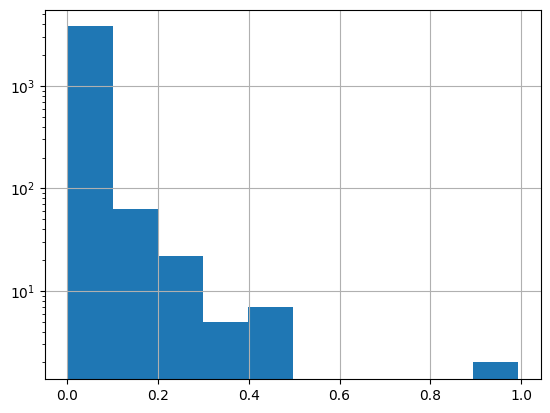

In [7]:
metrics_df["ptp_diff_rel"].hist(log=True)

<Axes: >

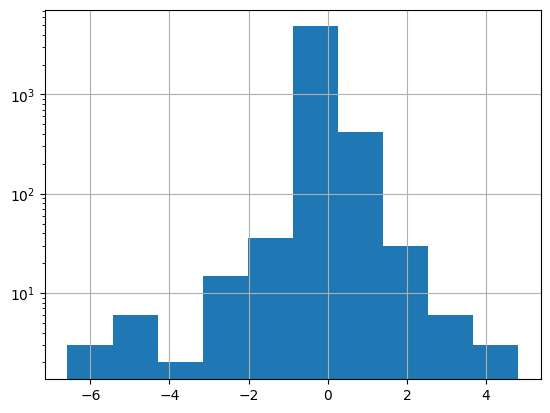

In [8]:
metrics_df["ss_value_diff_rel"].hist(log=True)

<Axes: >

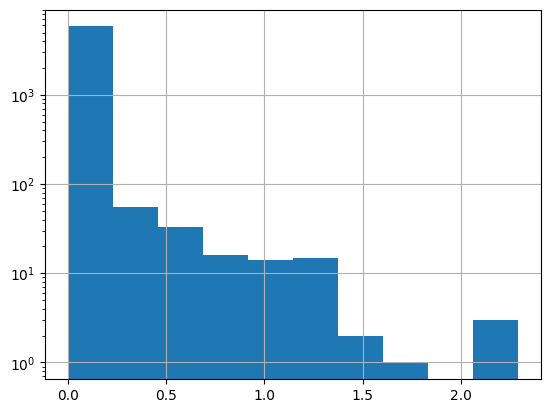

In [9]:
metrics_df["ss_time_diff"].hist(log=True)

### Biggest differences in main metrics

In [10]:
%matplotlib inline


def plot(el, var):
    colname = f"{el}_{var}"
    return plot_curves_comparison(reference_df, replayed_dfs[el], colname)

In [11]:
metrics_df.sort_values("ptp_diff_rel", ascending=False).head(5)

,element_id,variable,lib,ptp_ref,ptp_rep,ptp_diff,ss_value_ref,ss_value_rep,ss_value_diff,ss_time_ref,ss_time_rep,ss_time_diff,ptp_diff_rel,ss_value_diff_rel,r2,rmse,nrmse,mae
923,B19-G1,generator_MqSatPPu,GeneratorSynchronousThreeWindingsProportionalR...,1.000000e-06,5.771656e-09,9.942283e-07,0.88,8.800000e-01,8.115730e-14,0.0,0.0,0.0,0.994228,9.222421e-14,-0.000476,1.422562e-08,0.014226,2.571952e-10
922,B19-G1,generator_MdSatPPu,GeneratorSynchronousThreeWindingsProportionalR...,1.000000e-06,9.313388e-09,9.906866e-07,1.42,1.420000e+00,3.206324e-13,0.0,0.0,0.0,0.990687,2.257975e-13,-0.000730,1.422742e-08,0.014227,2.662921e-10
3834,B74-G1,generator_miPu,GeneratorSynchronousThreeWindingsProportionalR...,1.000000e-06,5.218365e-07,4.781635e-07,1.42,1.420000e+00,3.417266e-13,0.0,0.0,0.0,0.478164,2.406526e-13,-1.182702,7.473848e-08,0.074738,2.166360e-08
3949,B76-G1,generator_miPu,GeneratorSynchronousThreeWindingsProportionalR...,1.000000e-06,5.359081e-07,4.640919e-07,1.42,1.420000e+00,3.430589e-13,0.0,0.0,0.0,0.464092,2.415908e-13,-0.483524,7.506004e-08,0.075060,2.089498e-08
4071,B77-G1,generator_sin2Eta,GeneratorSynchronousThreeWindingsProportionalR...,1.000000e-06,5.548636e-07,4.451364e-07,0.00,2.722732e-55,2.722732e-55,0.0,0.0,0.0,0.445136,NaN,0.547026,8.175308e-08,0.081753,2.285975e-08


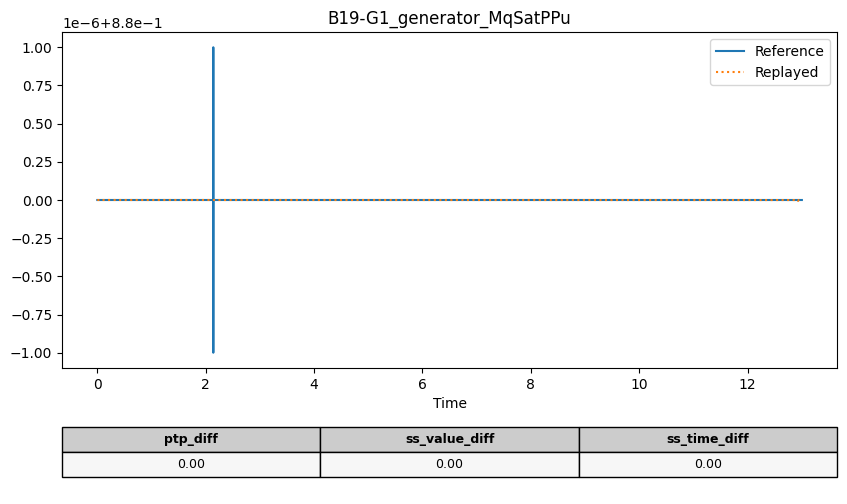

In [12]:
plot("B19-G1", "generator_MqSatPPu")

It is also important to note here (besides from the scale of the y-axis) that this generator is the one where the fault is produced.

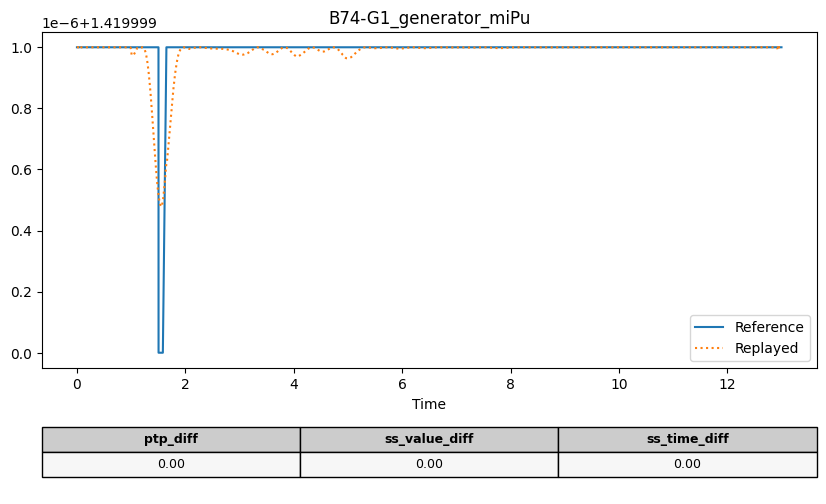

In [13]:
plot("B74-G1", "generator_miPu")

Note the scale of the y-axis.

In [14]:
metrics_df.sort_values("ptp_diff", ascending=False).head(5)

,element_id,variable,lib,ptp_ref,ptp_rep,ptp_diff,ss_value_ref,ss_value_rep,ss_value_diff,ss_time_ref,ss_time_rep,ss_time_diff,ptp_diff_rel,ss_value_diff_rel,r2,rmse,nrmse,mae
801,B15-G1,voltageRegulator_limiterWithLag_tUMaxReached,GeneratorSynchronousThreeWindingsProportionalR...,1.000000e+60,9.999987e+59,1.333171e+54,1.000000e+60,1.000000e+60,2.374583e+47,1.10,1.123104,0.023104,0.000001,2.374583e-13,0.941406,2.931817e+58,0.029318,2.597686e+57
916,B18-G1,voltageRegulator_limiterWithLag_tUMaxReached,GeneratorSynchronousThreeWindingsProportionalR...,1.000000e+60,9.999987e+59,1.333171e+54,1.000000e+60,1.000000e+60,2.374583e+47,1.10,1.123104,0.023104,0.000001,2.374583e-13,0.941406,2.931817e+58,0.029318,2.597686e+57
1031,B19-G1,voltageRegulator_limiterWithLag_tUMaxReached,GeneratorSynchronousThreeWindingsProportionalR...,1.000000e+60,9.999987e+59,1.333171e+54,1.000000e+60,1.000000e+60,2.374583e+47,1.10,1.123104,0.023104,0.000001,2.374583e-13,0.941406,2.931817e+58,0.029318,2.597686e+57
583,B12-G1,generator_QGen,GeneratorSynchronousFourWindingsProportionalRe...,2.307874e+02,2.195879e+02,1.119947e+01,9.127150e+01,9.127409e+01,2.586645e-03,7.64,7.630000,0.010000,0.048527,2.834012e-05,0.937457,6.498710e+00,0.028159,5.960106e-01
1503,B31-G1,generator_QGen,GeneratorSynchronousFourWindingsProportionalRe...,1.596028e+02,1.548128e+02,4.789940e+00,NaN,NaN,NaN,NaN,NaN,NaN,0.030012,NaN,0.938797,4.544582e+00,0.028474,4.122778e-01


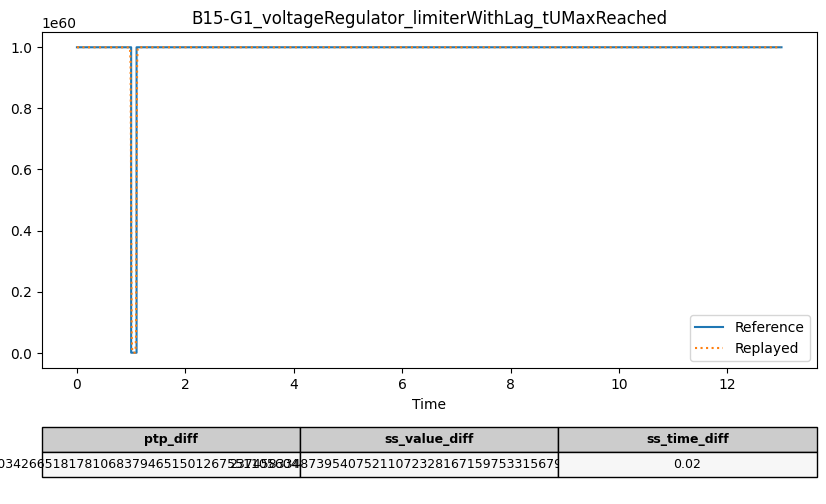

In [15]:
plot("B15-G1", "voltageRegulator_limiterWithLag_tUMaxReached")

In [16]:
metrics_df.sort_values("ss_value_diff_rel", ascending=False).head(5)

,element_id,variable,lib,ptp_ref,ptp_rep,ptp_diff,ss_value_ref,ss_value_rep,ss_value_diff,ss_time_ref,ss_time_rep,ss_time_diff,ptp_diff_rel,ss_value_diff_rel,r2,rmse,nrmse,mae
3725,B73-G1,generator_sStatorPu_re,GeneratorSynchronousThreeWindingsProportionalR...,0.005668,0.005367,0.000301,0.000001,0.000006,0.000005,4.020000,4.030000,0.010000,0.053114,4.814915,0.984566,0.000122,0.021595,0.000077
3587,B72-G1,generator_iQ1Pu,GeneratorSynchronousThreeWindingsProportionalR...,0.002306,0.002241,0.000065,0.000001,-0.000003,0.000004,0.000000,0.000000,0.000000,0.028031,4.435391,0.975505,0.000051,0.022270,0.000022
3955,B76-G1,generator_sStatorPu_re,GeneratorSynchronousThreeWindingsProportionalR...,0.005641,0.005419,0.000222,0.000005,-0.000017,0.000022,1.743468,1.739658,0.003810,0.039424,4.404767,0.984492,0.000097,0.017193,0.000062
6002,B113-G1,generator_iQ1Pu,GeneratorSynchronousThreeWindingsProportionalR...,0.037884,0.036642,0.001242,0.000001,0.000005,0.000004,2.556819,2.450000,0.106819,0.032784,3.673061,0.963104,0.000785,0.020731,0.000269
1632,B32-G1,generator_iQ1Pu,GeneratorSynchronousThreeWindingsProportionalR...,0.014111,0.013876,0.000235,0.000004,-0.000010,0.000014,2.230000,1.816090,0.413910,0.016629,3.556651,0.963537,0.000298,0.021102,0.000080


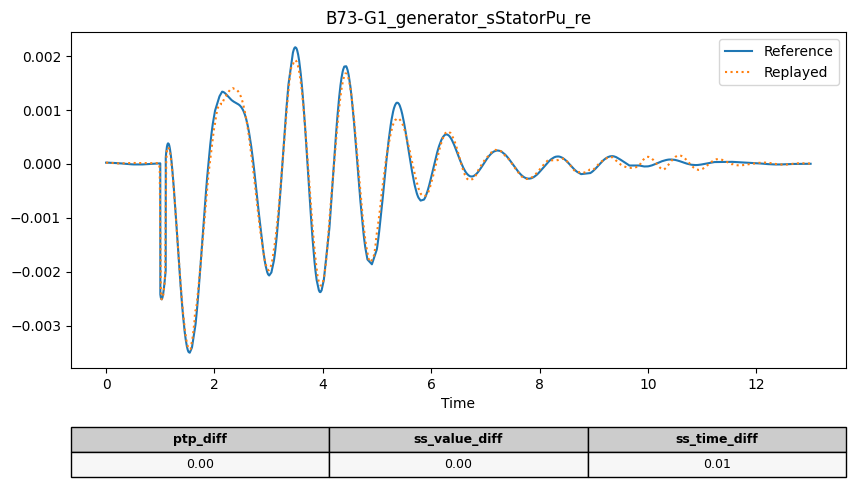

In [17]:
plot("B73-G1", "generator_sStatorPu_re")

In [18]:
metrics_df.sort_values("ss_time_diff", ascending=False).head(5)

,element_id,variable,lib,ptp_ref,ptp_rep,ptp_diff,ss_value_ref,ss_value_rep,ss_value_diff,ss_time_ref,ss_time_rep,ss_time_diff,ptp_diff_rel,ss_value_diff_rel,r2,rmse,nrmse,mae
6008,B113-G1,generator_iqPu,GeneratorSynchronousThreeWindingsProportionalR...,0.080379,0.079402,0.000977,-0.000026,-0.000019,0.000007,5.110000,2.820000,2.290000,0.012156,-0.252281,0.965853,0.001678,0.020877,0.000572
5986,B113-G1,generator_PePu,GeneratorSynchronousThreeWindingsProportionalR...,0.091868,0.091286,0.000582,0.000026,0.000020,0.000006,5.119971,2.830000,2.289971,0.006335,0.240793,0.962894,0.001954,0.021268,0.000606
5994,B113-G1,generator_cePu,GeneratorSynchronousThreeWindingsProportionalR...,0.091879,0.091306,0.000573,0.000026,0.000020,0.000006,5.119971,2.830000,2.289971,0.006241,0.240791,0.962885,0.001954,0.021272,0.000606
3735,B73-G1,generator_theta,GeneratorSynchronousThreeWindingsProportionalR...,0.008304,0.008231,0.000073,0.016770,0.016767,0.000003,3.960000,2.264344,1.695656,0.008733,0.000168,0.999511,0.000032,0.003846,0.000022
2555,B55-G1,generator_iStatorPu_re,GeneratorSynchronousThreeWindingsProportionalR...,0.003209,0.003076,0.000133,0.005083,0.005078,0.000005,1.560000,0.000000,1.560000,0.041478,0.000921,0.983788,0.000088,0.027333,0.000053


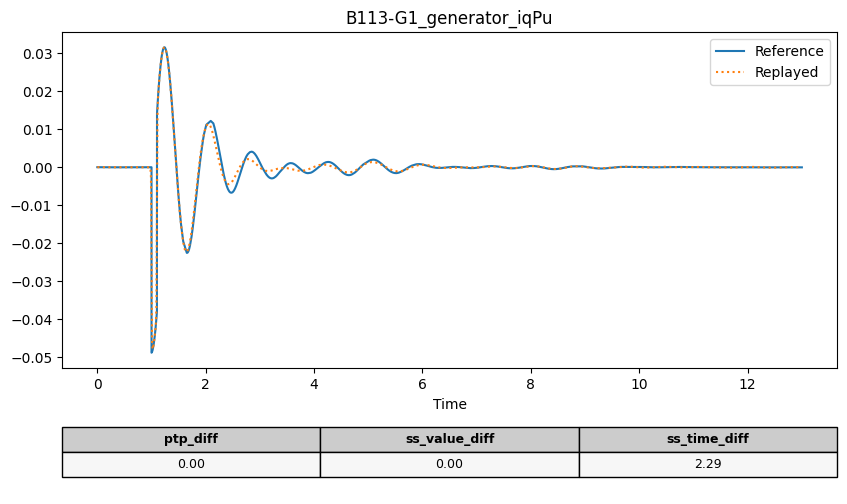

In [19]:
plot("B113-G1", "generator_iqPu")

### Boxplots per model library

<Axes: title={'center': 'ptp_diff_rel'}, xlabel='lib'>

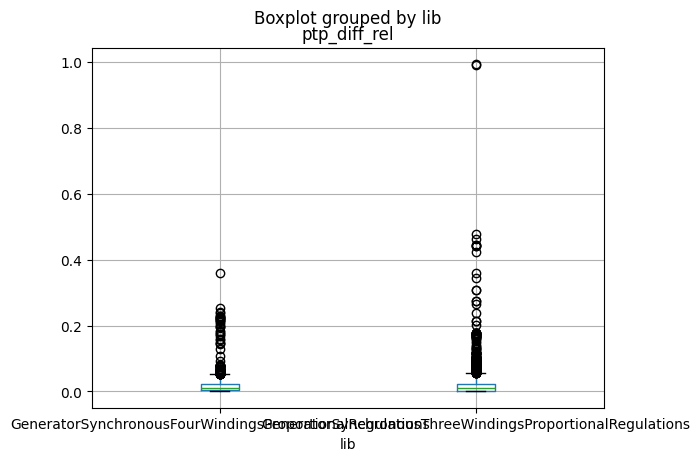

In [20]:
metrics_df.boxplot(column="ptp_diff_rel", by="lib")

<Axes: title={'center': 'ss_value_diff_rel'}, xlabel='lib'>

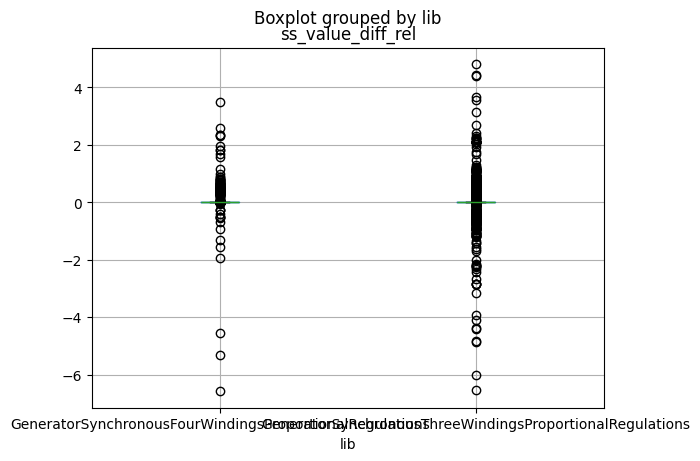

In [21]:
metrics_df.boxplot(column="ss_value_diff_rel", by="lib")

<Axes: title={'center': 'ss_time_diff'}, xlabel='lib'>

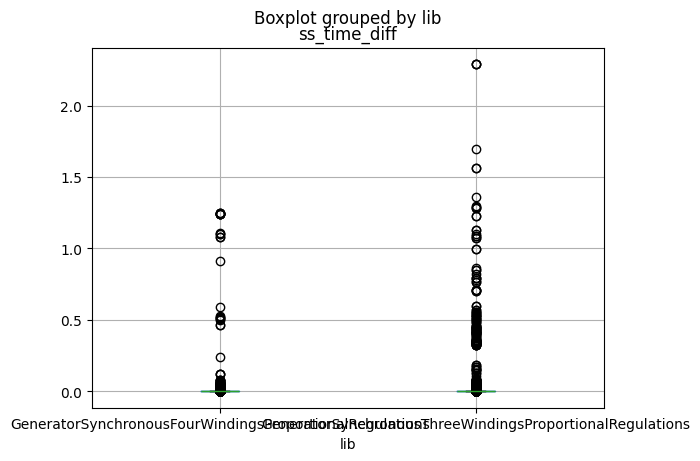

In [22]:
metrics_df.boxplot(column="ss_time_diff", by="lib")

### Analysis over distance to the fault

We will measure the distance to the fault as the number of lines between the buses to see if there is a correlation between the reconstruction error and the distance to the fault (in our case, in generatos `B19-G1`). In order to do that, we will create a graph of the network using the IIDM file and `networkx`. We also are going to use `pypowsybl` to read the IIDM file.

In [23]:
import networkx as nx
import pypowsybl

n = pypowsybl.network.load(case.base_folder / "IEEE118.iidm")
G = nx.Graph()
generators = n.get_generators()
buses = n.get_buses()
lines = n.get_lines()
print(f"{generators.shape=}, {buses.shape=}, {lines.shape=}")

for _id, row in buses.iterrows():
    G.add_node(_id, _type="bus", **row)
for _id, row in lines.iterrows():
    G.add_edge(row["bus1_id"], row["bus2_id"])
for _id, row in generators.iterrows():
    G.add_node(_id, _type="generator", **row)
    G.add_edge(_id, row["bus_id"])

G

generators.shape=(54, 19), buses.shape=(118, 6), lines.shape=(177, 19)


In [24]:
d = pd.Series(nx.single_source_dijkstra_path_length(G, source="B19-G1"))
d = d.loc[d.index.isin(generators.index)]
d = d.to_frame("distance")
d.head()

,distance
B19-G1,0
B15-G1,3
B18-G1,3
B34-G1,3
B36-G1,4


In [25]:
metrics_df_ext = metrics_df.merge(d, how="left", left_on="element_id", right_index=True)
metrics_df_ext

,element_id,variable,lib,ptp_ref,ptp_rep,ptp_diff,ss_value_ref,ss_value_rep,ss_value_diff,ss_time_ref,ss_time_rep,ss_time_diff,ptp_diff_rel,ss_value_diff_rel,r2,rmse,nrmse,mae,distance
0,B1-G1,generator_IRotorPu_value,GeneratorSynchronousThreeWindingsProportionalR...,0.184885,1.783588e-01,6.526242e-03,9.337990e-01,9.338064e-01,7.446547e-06,3.380000,3.38,0.000000,0.035299,7.974464e-06,9.598740e-01,3.811435e-03,0.020615,3.628130e-04,7.0
1,B1-G1,generator_IStatorPu_value,GeneratorSynchronousThreeWindingsProportionalR...,0.332413,3.214097e-01,1.100329e-02,3.252000e-02,3.250532e-02,1.468152e-05,4.477649,4.48,0.002351,0.033101,4.514612e-04,9.372672e-01,8.809055e-03,0.026500,8.414587e-04,7.0
2,B1-G1,generator_MdSatPPu,GeneratorSynchronousThreeWindingsProportionalR...,0.000000,9.313386e-09,9.313386e-09,1.420000e+00,1.420000e+00,3.417266e-13,0.000000,0.00,0.000000,NaN,2.406526e-13,-1.972730e+12,3.118703e-10,NaN,2.341258e-11,7.0
3,B1-G1,generator_MqSatPPu,GeneratorSynchronousThreeWindingsProportionalR...,0.000000,5.771658e-09,5.771658e-09,8.800000e-01,8.800000e-01,7.693846e-14,0.000000,0.00,0.000000,NaN,8.743006e-14,-7.575384e+11,1.932603e-10,NaN,1.439411e-11,7.0
4,B1-G1,generator_PGen,GeneratorSynchronousThreeWindingsProportionalR...,9.211557,9.191482e+00,2.007514e-02,NaN,NaN,NaN,NaN,NaN,NaN,0.002179,NaN,9.670892e-01,2.009348e-01,0.021813,4.141406e-02,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6205,B116-G1,voltageRegulator_limiterWithLag_initSaturatedMin,GeneratorSynchronousThreeWindingsProportionalR...,0.000000,0.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00,0.000000,0.00,0.000000,NaN,-0.000000e+00,1.000000e+00,0.000000e+00,NaN,0.000000e+00,NaN
6206,B116-G1,voltageRegulator_limiterWithLag_tUMaxReached,GeneratorSynchronousThreeWindingsProportionalR...,0.000000,0.000000e+00,0.000000e+00,1.000000e+60,1.000000e+60,0.000000e+00,0.000000,0.00,0.000000,NaN,0.000000e+00,1.000000e+00,0.000000e+00,NaN,0.000000e+00,NaN
6207,B116-G1,voltageRegulator_limiterWithLag_tUMinReached,GeneratorSynchronousThreeWindingsProportionalR...,0.000000,0.000000e+00,0.000000e+00,1.000000e+60,1.000000e+60,0.000000e+00,0.000000,0.00,0.000000,NaN,0.000000e+00,1.000000e+00,0.000000e+00,NaN,0.000000e+00,NaN
6208,B116-G1,voltageRegulator_limiterWithLag_u,GeneratorSynchronousThreeWindingsProportionalR...,0.147551,1.474177e-01,1.333217e-04,1.337941e+00,1.337940e+00,1.410988e-06,1.990000,1.99,0.000000,0.000904,1.054596e-06,9.518913e-01,3.586990e-03,0.024310,3.321688e-04,NaN


In [ ]:
def plot_over_distance(metric):
    corr = metrics_df_ext[metric].corr(metrics_df_ext["distance"])
    plt.scatter(metrics_df_ext["distance"], metrics_df_ext[metric])
    plt.title(f"{metric} vs Distance ({corr=:.2f})")
    plt.xlabel(metric)
    plt.xlabel("Distance")

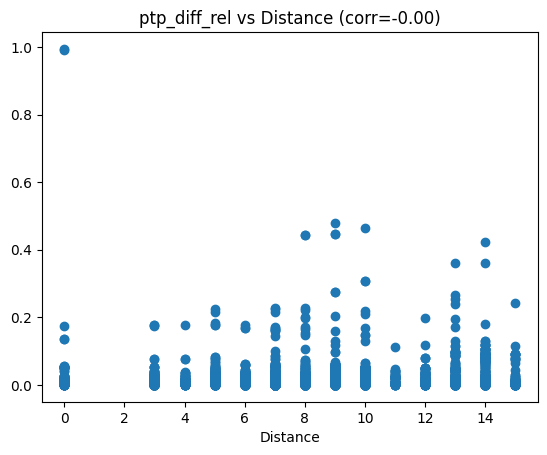

In [27]:
plot_over_distance("ptp_diff_rel")

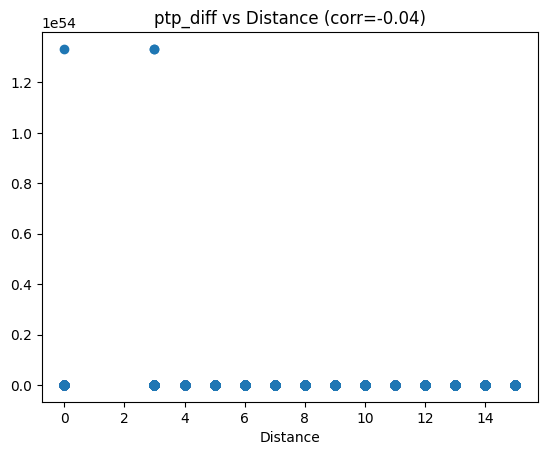

In [28]:
plot_over_distance("ptp_diff")

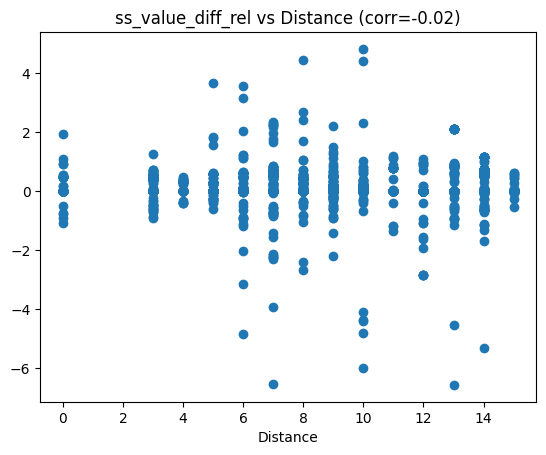

In [29]:
plot_over_distance("ss_value_diff_rel")

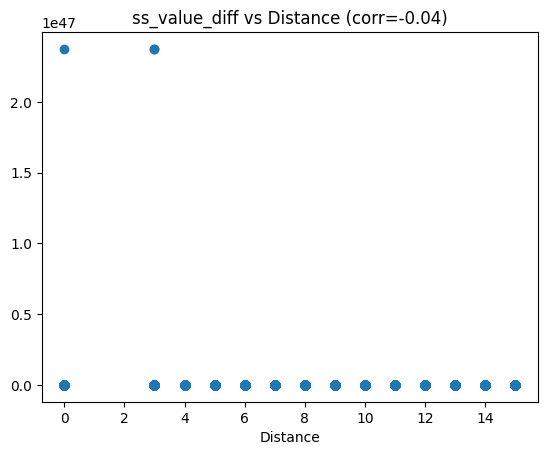

In [30]:
plot_over_distance("ss_value_diff")

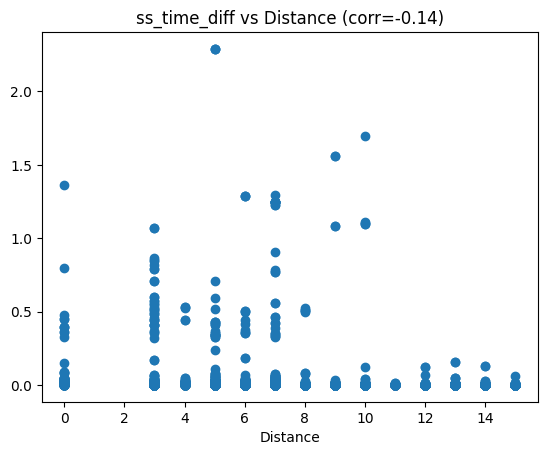

In [31]:
plot_over_distance("ss_time_diff")

No correlation is shown.